<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span><ul class="toc-item"><li><span><a href="#Imports-and-configurations" data-toc-modified-id="Imports-and-configurations-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports and configurations</a></span></li><li><span><a href="#Data-set-preparation:-POLLEN" data-toc-modified-id="Data-set-preparation:-POLLEN-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data set preparation: POLLEN</a></span></li></ul></li><li><span><a href="#Run-models" data-toc-modified-id="Run-models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Run models</a></span><ul class="toc-item"><li><span><a href="#Factor-Analysis" data-toc-modified-id="Factor-Analysis-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Factor Analysis</a></span></li><li><span><a href="#ZIFA" data-toc-modified-id="ZIFA-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>ZIFA</a></span></li><li><span><a href="#pCMF" data-toc-modified-id="pCMF-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>pCMF</a></span></li><li><span><a href="#ZINB-WaVE" data-toc-modified-id="ZINB-WaVE-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>ZINB-WaVE</a></span></li><li><span><a href="#scVI" data-toc-modified-id="scVI-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>scVI</a></span></li><li><span><a href="#m-pCMF" data-toc-modified-id="m-pCMF-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>m-pCMF</a></span></li><li><span><a href="#ZINBayes" data-toc-modified-id="ZINBayes-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>ZINBayes</a></span></li></ul></li><li><span><a href="#Plot-results" data-toc-modified-id="Plot-results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot results</a></span><ul class="toc-item"><li><span><a href="#Latent-space-clustering" data-toc-modified-id="Latent-space-clustering-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Latent space clustering</a></span><ul class="toc-item"><li><span><a href="#Correlation-with-quality-metrics" data-toc-modified-id="Correlation-with-quality-metrics-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Correlation with quality metrics</a></span></li></ul></li><li><span><a href="#Held-out-data-log-likelihood" data-toc-modified-id="Held-out-data-log-likelihood-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Held-out data log-likelihood</a></span></li><li><span><a href="#Imputation-error" data-toc-modified-id="Imputation-error-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Imputation error</a></span></li><li><span><a href="#Technical-variability" data-toc-modified-id="Technical-variability-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Technical variability</a></span></li><li><span><a href="#Gene-groups" data-toc-modified-id="Gene-groups-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Gene groups</a></span></li><li><span><a href="#Differential-Expression" data-toc-modified-id="Differential-Expression-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Differential Expression</a></span></li></ul></li></ul></div>

# Initialization

## Imports and configurations

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
# %matplotlib inline

from zinbayes.zinbayes import ZINBayes

from pCMF import mpCMF

from state_of_art.scVI.scvi import scVI
from state_of_art.ZIFA.zifa import ZIFA
from state_of_art.ZINB_WaVE.zinb_wave import ZINB_WaVE
from state_of_art.pCMF.pcmf import pCMF

from misc.model_wrapper import ModelWrapper
from misc import print_utils, plot_utils

import edward as ed
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from scipy.stats import gaussian_kde, pearsonr
import pandas as pd
from sklearn.decomposition import FactorAnalysis
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.preprocessing import OneHotEncoder

from edward.models import Beta, RelaxedBernoulli, Gamma, Poisson, Dirichlet, Mixture, Categorical, TransformedDistribution, Normal, PointMass

plt.style.use('seaborn-whitegrid')

In [3]:
# scatter plots style
s = 30
alpha = 0.5

## Data set preparation: POLLEN

In [4]:
data_path = '../../data/Pollen'
X = pd.read_csv(data_path + '/counts.csv').T
y = pd.read_csv(data_path + '/labels.csv')
b = pd.read_csv(data_path + '/batches.csv')


y = np.array(y)[:, 1]
y_names, y_id = np.unique(y, return_inverse=True)
celltypes = y_names

b = np.array(b)[:, 1]
b_names, b_id = np.unique(b, return_inverse=True)
coverage = b_names

b_onehot = OneHotEncoder().fit_transform(b_id.reshape(-1, 1)).toarray()

X = np.array(X)
gene_names = X[0, :]
X = np.array(X[1:, :], dtype=np.float32)
var_genes = np.var(X, axis=0)
X = X[:, np.argsort(var_genes)[-1000:]]

n_cells = X.shape[0]
n_genes = X.shape[1]
n_types = np.unique(y).size
n_batches = np.unique(b).size

print('Data shape:')
print('{} cells, {} genes\n'.format(X.shape[0], X.shape[1]))
print('{} cell types\n'.format(n_types))
print('{} experimental batches\n'.format(n_batches))
print('Percentage of zeros in the data set:')
print('{:.2f}%'.format(np.count_nonzero(X==0) / X.size * 100))

Data shape:
130 cells, 1000 genes

4 cell types

2 experimental batches

Percentage of zeros in the data set:
32.84%


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [5]:
labels = y_id
clusters = y

In [7]:
X_train, X_test, c_train, c_test = train_test_split(X, labels, test_size=0.3)

In [8]:
N = X_train.shape[0]
N_test = X_test.shape[0]
P = n_genes
C = n_types

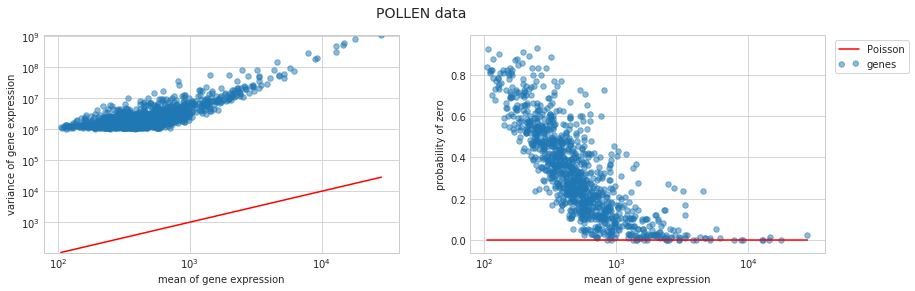

In [9]:
n_cells = X.shape[0]
n_genes = X.shape[1]

genecounts_mean = np.mean(X, axis=0)
genecounts_var = np.var(X, axis=0)

x = np.linspace(genecounts_mean.min(), genecounts_mean.max(), num=100000)
r_ = .1

s = 30
alpha = 0.5

fig = plt.figure(figsize=(14, 4))
ax = plt.subplot(1, 2, 1)
plt.xscale('log')
plt.yscale('log')
plt.scatter(genecounts_mean, genecounts_var, s=s, alpha=alpha)
plt.plot(x, x, color='red')
# plt.plot(x, x + 1/r_ * x**2, color='red')
plt.xlabel('mean of gene expression')
plt.ylabel('variance of gene expression')
plt.ylim(min(genecounts_mean.min(), genecounts_var.min()), max(genecounts_mean.max(), genecounts_var.max()))

# Dropout probability of each gene: number of cells with zero count of that gene / total number of cells
dropout_prob = np.sum(X==0, axis=0) / n_cells

x = np.linspace(genecounts_mean.min(), genecounts_mean.max(), num=100000)
poi_zeros = np.exp(-x)
nb_zeros = (r_/(x + r_))**r_

ax = plt.subplot(1, 2, 2)
plt.xscale('log')
plt.scatter(genecounts_mean, dropout_prob, label='genes', s=s, alpha=alpha)
plt.plot(x, poi_zeros, color='red', label='Poisson')
# plt.plot(x, nb_zeros, color='red', label='NB (r={})'.format(r_))
plt.xlabel('mean of gene expression')
plt.ylabel('probability of zero')
plt.legend(scatterpoints=2, frameon=True, bbox_to_anchor=[1.25, 1.0])

plt.suptitle('POLLEN data', fontsize=14)
# plt.savefig('PBMC_Poisson.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Run models
For each model, we need:
* 5 repetitions on the full data set, for clustering benchmarking. 
    - Keep the best run and:
         - perform t-SNE;
         - get m-pCMF and ZINBayes' cell scalings.
* 5-fold cross-validation to compute the held-out data log-likelihood.
* Run on 5 different corrupted full data sets for imputation benchmarking.

(ensure scVI does not separate the data more than we want it to.)

In [10]:
K = 2

## Factor Analysis

In [11]:
obj = FactorAnalysis(n_components=K)
fa = ModelWrapper(obj, X, c_train=labels, b_train=b_onehot, name='FA', do_imp=False, log_data=True)
fa.run(do_silh=True, do_dll=False, do_holl=False, do_tsne=False, do_batch=True, do_corr=True, verbose=True)

Running FA...
Some arguments were ignored by FactorAnalysis.
Running .fit_transform() without keyword arguments.
Done.


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [13]:
fa.asw, fa.ari, fa.nmi, fa.batch_asw, fa.corr_1_dr, fa.corr_2_dr, fa.corr_1_ls, fa.corr_2_ls

(0.013827787251027247,
 0.0813919570610741,
 0.16228063888308852,
 0.4584297557023806,
 0.7616585084539446,
 0.20329443224622376,
 0.992151882959079,
 0.0019108685642019372)

In [13]:
# 5 repetitions on the full data set
fa_full_reps = []

for i in range(5):
    print('Run {}...'.format(i))
    obj = FactorAnalysis(n_components=K)
    fa = ModelWrapper(obj, X, c_train=labels, b_train=b_onehot, name='FA', do_imp=False, log_data=True)
    fa.run(do_silh=True, do_dll=False, do_holl=False, do_tsne=False, do_batch=True, verbose=True)
    
    fa_full_reps.append(fa)
    print('Done.\n')

Run 0...
Running FA...
Some arguments were ignored by FactorAnalysis.
Running .fit_transform() without keyword arguments.


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Done.
Done.

Run 1...
Running FA...
Some arguments were ignored by FactorAnalysis.
Running .fit_transform() without keyword arguments.


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Done.
Done.

Run 2...
Running FA...
Some arguments were ignored by FactorAnalysis.
Running .fit_transform() without keyword arguments.


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Done.
Done.

Run 3...
Running FA...
Some arguments were ignored by FactorAnalysis.
Running .fit_transform() without keyword arguments.


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Done.
Done.

Run 4...
Running FA...
Some arguments were ignored by FactorAnalysis.
Running .fit_transform() without keyword arguments.
Done.
Done.



/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [14]:
# 5-fold cross-validation 
fa_cv = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 0
for train_idx, test_idx in kf.split(X):
    fold = fold + 1
    print('Fold {}...'.format(fold))
    X_train = X[train_idx]
    X_test = X[test_idx]

    obj = FactorAnalysis(n_components=K)
    fa = ModelWrapper(obj, X_train, X_test=X_test, name='FA', log_data=True, do_imp=False)
    fa.run(do_silh=False, do_dll=True, do_holl=True, do_tsne=False, verbose=True)
    
    fa_cv.append(fa)
    print('Done.\n')

Fold 1...
Running FA...
Some arguments were ignored by FactorAnalysis.
Running .fit_transform() without keyword arguments.
Evaluating train-data log-likelihood...
Evaluating test-data log-likelihood...
Done.
Done.

Fold 2...
Running FA...
Some arguments were ignored by FactorAnalysis.
Running .fit_transform() without keyword arguments.
Evaluating train-data log-likelihood...
Evaluating test-data log-likelihood...
Done.
Done.

Fold 3...
Running FA...
Some arguments were ignored by FactorAnalysis.
Running .fit_transform() without keyword arguments.
Evaluating train-data log-likelihood...
Evaluating test-data log-likelihood...
Done.
Done.

Fold 4...
Running FA...
Some arguments were ignored by FactorAnalysis.
Running .fit_transform() without keyword arguments.
Evaluating train-data log-likelihood...
Evaluating test-data log-likelihood...
Done.
Done.

Fold 5...
Running FA...
Some arguments were ignored by FactorAnalysis.
Running .fit_transform() without keyword arguments.
Evaluating train-

## ZIFA

In [16]:
obj = ZIFA(n_components=K)
zifa = ModelWrapper(obj, X, c_train=labels, b_train=b_onehot, name='ZIFA', log_data=True, do_imp=False)
zifa.run(max_iter=1000, do_silh=True, max_time=60*60, do_dll=False, do_holl=False, do_tsne=False, do_batch=True, do_corr=True, verbose=True)

Running ZIFA...
Some arguments were ignored by ZIFA.


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Param change below threshold 1.000e-02 after 8 iterations
Done.


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [17]:
zifa.asw, zifa.ari, zifa.nmi, zifa.batch_asw, zifa.corr_1_dr, zifa.corr_2_dr, zifa.corr_1_ls, zifa.corr_2_ls

(0.00169009404779155,
 0.0813919570610741,
 0.16228063888308852,
 0.46279040612268224,
 0.7303783539294428,
 0.21180677179202326,
 0.9866552348212368,
 0.010573691697808743)

In [15]:
# 5 repetitions on the full data set
zifa_full_reps = []

for i in range(5):
    print('Run {}...'.format(i))
    obj = ZIFA(n_components=K)
    zifa = ModelWrapper(obj, X, c_train=labels, b_train=b_onehot, name='ZIFA', log_data=True, do_imp=False)
    zifa.run(max_iter=1000, do_silh=True, max_time=60*60, do_dll=False, do_holl=False, do_tsne=False, do_batch=True, verbose=True)
    
    zifa_full_reps.append(zifa)
    print('Done.\n')

Run 0...
Running ZIFA...
Some arguments were ignored by ZIFA.


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Param change below threshold 1.000e-02 after 8 iterations


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Done.
Done.

Run 1...
Running ZIFA...
Some arguments were ignored by ZIFA.


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Param change below threshold 1.000e-02 after 8 iterations


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/ubuntu/thesis/venv/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Done.
Done.

Run 2...
Running ZIFA...
Some arguments were ignored by ZIFA.
Param change below threshold 1.000e-02 after 8 iterations


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Done.
Done.

Run 3...
Running ZIFA...
Some arguments were ignored by ZIFA.


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Param change below threshold 1.000e-02 after 8 iterations


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Done.
Done.

Run 4...
Running ZIFA...
Some arguments were ignored by ZIFA.


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Param change below threshold 1.000e-02 after 8 iterations
Done.
Done.



/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [16]:
# 5-fold cross-validation 
zifa_cv = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 0
for train_idx, test_idx in kf.split(X):
    fold = fold + 1
    print('Fold {}...'.format(fold))
    X_train = X[train_idx]
    X_test = X[test_idx]

    obj = ZIFA(n_components=K)
    zifa = ModelWrapper(obj, X_train, X_test=X_test, log_data=True, name='ZIFA')
    zifa.run(max_time=60*60, max_iter=100, do_silh=False, do_dll=True, do_holl=True, do_tsne=False, verbose=True)
    
    zifa_cv.append(zifa)
    print('Done.\n')

Fold 1...
Running ZIFA...
Some arguments were ignored by ZIFA.


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Param change below threshold 1.000e-02 after 8 iterations
Evaluating train-data log-likelihood...
Evaluating test-data log-likelihood...
Done.
Done.

Fold 2...
Running ZIFA...
Some arguments were ignored by ZIFA.


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Param change below threshold 1.000e-02 after 8 iterations
Evaluating train-data log-likelihood...


KeyboardInterrupt: 

In [17]:
# 5 corrupted data sets
zifa_imputation = []

for i in range(5):
    print('Run {}...'.format(i))
    obj = ZIFA(n_components=K)
    zifa = ModelWrapper(obj, X, X_test=None, log_data=True, name='ZIFA', do_imp=True)
    zifa.run(max_time=60*60, max_iter=100, do_silh=False, do_dll=False, do_holl=False, do_tsne=False, verbose=True)
    
    zifa_imputation.append(zifa)
    print('Done.\n')

Run 0...
Running ZIFA...
Some arguments were ignored by ZIFA.


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Param change below threshold 1.000e-02 after 6 iterations
Done.
Done.

Run 1...
Running ZIFA...
Some arguments were ignored by ZIFA.


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Param change below threshold 1.000e-02 after 8 iterations
Done.
Done.

Run 2...
Running ZIFA...
Some arguments were ignored by ZIFA.


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Param change below threshold 1.000e-02 after 6 iterations
Done.
Done.

Run 3...
Running ZIFA...
Some arguments were ignored by ZIFA.


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Param change below threshold 1.000e-02 after 7 iterations
Done.
Done.

Run 4...
Running ZIFA...
Some arguments were ignored by ZIFA.


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Param change below threshold 1.000e-02 after 6 iterations
Done.
Done.



## pCMF

In [18]:
obj = pCMF(n_components=K)
pcmf = ModelWrapper(obj, X, c_train=labels, b_train=b_onehot, name='pCMF', log_data=False, do_imp=False)
pcmf.run(max_iter=400, do_silh=True, do_dll=False, do_holl=False, do_tsne=False, verbose=True, do_batch=True, do_corr=True)

Running pCMF...
Some arguments were ignored by pCMF.
Declaration


Initialization


Optimization


iter 
0


iter 
10


iter 
20


iter 
30


iter 
40


iter 
50


iter 
60


iter 
70


iter 
80


iter 
90


iter 
100


iter 
110


iter 
120


iter 
130


iter 
140


iter 
150


iter 
160


iter 
170


iter 
180


iter 
190


iter 
200


iter 
210


iter 
220


iter 
230


iter 
240


iter 
250


Order factor


Output


Done.


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [19]:
pcmf.asw, pcmf.ari, pcmf.nmi, pcmf.batch_asw, pcmf.corr_1_dr, pcmf.corr_2_dr, pcmf.corr_1_ls, pcmf.corr_2_ls

(-0.13884731051424878,
 -0.004134519783890378,
 0.061122305454832944,
 0.6471724170998239,
 0.4075340147274712,
 0.33984376977967545,
 0.9828755796744547,
 0.9676895645136471)

In [22]:
# 5 repetitions on the full data set
pcmf_full_reps = []

for i in range(5):
    print('Run {}...'.format(i))
    obj = pCMF(n_components=K)
    pcmf = ModelWrapper(obj, X, c_train=labels, b_train=b_onehot, name='pCMF', log_data=False, do_imp=False)
    pcmf.run(max_iter=500, do_silh=True, do_dll=False, do_holl=False, do_tsne=False, verbose=True, do_batch=True)
    
    pcmf_full_reps.append(pcmf)
    print('Done.\n')

Run 0...
Running pCMF...
Some arguments were ignored by pCMF.
Declaration


Initialization


Optimization


iter 
0


iter 
10


iter 
20


iter 
30


iter 
40


iter 
50


iter 
60


iter 
70


iter 
80


iter 
90


iter 
100


iter 
110


iter 
120


iter 
130


iter 
140


iter 
150


iter 
160


iter 
170


iter 
180


iter 
190


iter 
200


iter 
210


iter 
220


iter 
230


iter 
240


iter 
250


Order factor


Output


Done.
Done.

Run 1...
Running pCMF...
Some arguments were ignored by pCMF.
Declaration


Initialization


Optimization


iter 
0




/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


iter 
10


iter 
20


iter 
30


iter 
40


iter 
50


iter 
60


iter 
70


iter 
80


iter 
90


iter 
100


iter 
110


iter 
120


iter 
130


iter 
140


iter 
150


iter 
160


iter 
170


iter 
180


iter 
190


iter 
200


iter 
210


iter 
220


iter 
230


iter 
240


iter 
250


Order factor


Output


Done.
Done.

Run 2...
Running pCMF...
Some arguments were ignored by pCMF.
Declaration


Initialization


Optimization


iter 
0




/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


iter 
10


iter 
20


iter 
30


iter 
40


iter 
50


iter 
60


iter 
70


iter 
80


iter 
90


iter 
100


iter 
110


iter 
120


iter 
130


iter 
140


iter 
150


iter 
160


iter 
170


iter 
180


iter 
190


iter 
200


iter 
210


iter 
220


iter 
230


iter 
240


iter 
250


Order factor


Output


Done.
Done.

Run 3...
Running pCMF...
Some arguments were ignored by pCMF.
Declaration


Initialization


Optimization


iter 
0




/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


iter 
10


iter 
20


iter 
30


iter 
40


iter 
50


iter 
60


iter 
70


iter 
80


iter 
90


iter 
100


iter 
110


iter 
120


iter 
130


iter 
140


iter 
150


iter 
160


iter 
170


iter 
180


iter 
190


iter 
200


iter 
210


iter 
220


iter 
230


iter 
240


iter 
250


Order factor


Output


Done.
Done.

Run 4...
Running pCMF...
Some arguments were ignored by pCMF.
Declaration


Initialization


Optimization


iter 
0


iter 
10




/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


iter 
20


iter 
30


iter 
40


iter 
50


iter 
60


iter 
70


iter 
80


iter 
90


iter 
100


iter 
110


iter 
120


iter 
130


iter 
140


iter 
150


iter 
160


iter 
170


iter 
180


iter 
190


iter 
200


iter 
210


iter 
220


iter 
230


iter 
240


iter 
250


Order factor


Output


Done.
Done.



/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [ ]:
# No HOLL test

In [19]:
# 5 repetitions on the full data set
pcmf_imputation = []

for i in range(5):
    print('Run {}...'.format(i))
    obj = pCMF(n_components=K)
    pcmf = ModelWrapper(obj, X, name='pCMF', log_data=False, do_imp=True)
    pcmf.run(max_iter=500, do_silh=False, do_dll=False, do_holl=False, do_tsne=False, verbose=True)
    
    pcmf_imputation.append(pcmf)
    print('Done.\n')

Run 0...
Running pCMF...
Some arguments were ignored by pCMF.
Declaration


Initialization


Optimization


iter 
0


iter 
10


iter 
20


iter 
30


iter 
40


iter 
50


iter 
60


iter 
70


iter 
80


iter 
90


iter 
100


iter 
110


iter 
120


iter 
130


iter 
140


iter 
150


iter 
160


iter 
170


iter 
180


iter 
190


iter 
200


iter 
210


iter 
220


iter 
230


iter 
240


iter 
250


Order factor


Output


Done.
Done.

Run 1...
Running pCMF...
Some arguments were ignored by pCMF.
Declaration


Initialization


Optimization


iter 
0


iter 
10


iter 
20


iter 
30


iter 
40


iter 
50


iter 
60


iter 
70


iter 
80


iter 
90


iter 
100


iter 
110


iter 
120


iter 
130


iter 
140


iter 
150


iter 
160


iter 
170


iter 
180


iter 
190


iter 
200


iter 
210


iter 
220


iter 
230


iter 
240


iter 
250


Order factor


Output


Done.
Done.

Run 2...
Running pCMF...
Some arguments were ignored by pCMF.
Declaration


Initialization


Optimization




## ZINB-WaVE

In [20]:
obj = ZINB_WaVE(n_components=K)
zinbwave = ModelWrapper(obj, X, c_train=labels, b_train=b_onehot, name='ZINB-WaVE', log_data=False, do_imp=False)
zinbwave.run(do_silh=True, do_dll=False, do_holl=False, do_tsne=False, do_batch=True, do_corr=True, verbose=True)

Running ZINB-WaVE...
Some arguments were ignored by ZINB_WaVE.
Running .fit_transform() without keyword arguments.
Done.


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [21]:
zinbwave.asw, zinbwave.ari, zinbwave.nmi, zinbwave.batch_asw, zinbwave.corr_1_dr, zinbwave.corr_2_dr, zinbwave.corr_1_ls, zinbwave.corr_2_ls

(0.21875978576315175,
 0.3197603525238725,
 0.478962397834613,
 -0.010821533419919137,
 0.48337675375566636,
 0.3082559419123327,
 0.05197098867370946,
 0.12616185577061775)

In [48]:
# 5 repetitions on the full data set
zinbwave_full_reps = []

for i in range(5):
    print('Run {}...'.format(i))
    obj = ZINB_WaVE(n_components=K)
    zinbwave = ModelWrapper(obj, X, c_train=labels, b_train=b_onehot, name='ZINB-WaVE', log_data=False, do_imp=False)
    zinbwave.run(do_silh=True, do_dll=False, do_holl=False, do_tsne=False, do_batch=True, verbose=True)
    
    zinbwave_full_reps.append(zinbwave)
    print('Done.\n')

Run 0...
Running ZINB-WaVE...
Some arguments were ignored by ZINB_WaVE.
Running .fit_transform() without keyword arguments.


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Done.
Done.

Run 1...
Running ZINB-WaVE...
Some arguments were ignored by ZINB_WaVE.
Running .fit_transform() without keyword arguments.


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Done.
Done.

Run 2...
Running ZINB-WaVE...
Some arguments were ignored by ZINB_WaVE.
Running .fit_transform() without keyword arguments.


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Done.
Done.

Run 3...
Running ZINB-WaVE...
Some arguments were ignored by ZINB_WaVE.
Running .fit_transform() without keyword arguments.


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Done.
Done.

Run 4...
Running ZINB-WaVE...
Some arguments were ignored by ZINB_WaVE.
Running .fit_transform() without keyword arguments.
Done.
Done.



/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [81]:
# 5-fold cross-validation 
zinbwave_cv = []

kf = KFold(n_splits=5, shuffle=True)
fold = 0
for train_idx, test_idx in kf.split(X):
    fold = fold + 1
    print('Fold {}...'.format(fold))
    X_train = X[train_idx]
    X_test = X[test_idx]

    obj = ZINB_WaVE(n_components=K)
    zinbwave = ModelWrapper(obj, X_train, X_test=X_test, name='ZINB-WaVE', log_data=False, do_imp=False)
    zinbwave.run(do_silh=False, do_dll=True, do_holl=True, do_tsne=False, verbose=True)
    
    zinbwave_cv.append(zinbwave)
    print('Done.\n')

Fold 1...
Running ZINB-WaVE...
Some arguments were ignored by ZINB_WaVE.
Running .fit_transform() without keyword arguments.
Evaluating train-data log-likelihood...
Evaluating test-data log-likelihood...


RRuntimeError: Error in zinbInitialize(m_val, matrix_val) : Gene 235 has only 0 counts!


In [80]:
X_train[:, 22]

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3910e+03, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 1.1769e+04, 7.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 5.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3000e+01, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       1.7000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 5.8900e+02, 0.0000e+00, 0.0000e+00, 0.0000e

In [32]:
# 5 repetitions on the full data set
zinbwave_imputation = []

for i in range(5):
    print('Run {}...'.format(i))
    obj = ZINB_WaVE(n_components=K)
    zinbwave = ModelWrapper(obj, X, name='ZINB-WaVE', log_data=False, do_imp=True)
    zinbwave.run(max_iter=1000, do_silh=False, do_dll=False, do_holl=False, do_tsne=False, verbose=True)
    
    zinbwave_imputation.append(zinbwave)
    print('Done.\n')

Run 0...
Running ZINB-WaVE...
Some arguments were ignored by ZINB_WaVE.
Running .fit_transform() without keyword arguments.
Done.
Done.

Run 1...
Running ZINB-WaVE...
Some arguments were ignored by ZINB_WaVE.
Running .fit_transform() without keyword arguments.
Done.
Done.

Run 2...
Running ZINB-WaVE...
Some arguments were ignored by ZINB_WaVE.
Running .fit_transform() without keyword arguments.
Done.
Done.

Run 3...
Running ZINB-WaVE...
Some arguments were ignored by ZINB_WaVE.
Running .fit_transform() without keyword arguments.
Done.
Done.

Run 4...
Running ZINB-WaVE...
Some arguments were ignored by ZINB_WaVE.
Running .fit_transform() without keyword arguments.
Done.
Done.



## scVI

In [24]:
obj = scVI(n_components=K, n_hidden=128, n_layers=1, batch_size=128, batches=True)
scvi = ModelWrapper(obj, X, c_train=labels, b_train=b_onehot, name='scVI', do_imp=False)
scvi.run(max_iter=1000, do_silh=True, max_time=60*5, do_dll=False, do_holl=False, do_batch=True, do_tsne=False, do_corr=True, verbose=True)

Running scVI...
Running scVI on 1000 genes
Got 2batches in the data
Will not apply a MMD penalty
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
Will apply zero inflation
Will apply cell-specific scalings
1 hidden layers at 128 each for a final 2 latent space
Done.tion 1000/1000. Train loss: 12138.522. Elapsed: 0h0m27s


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [25]:
scvi.asw, scvi.ari, scvi.nmi, scvi.batch_asw, scvi.corr_1_dr, scvi.corr_2_dr, scvi.corr_1_ls, scvi.corr_2_ls

(0.08947327,
 0.2905333566631734,
 0.37339760800055494,
 0.062741034,
 0.17881517777896683,
 0.723738456159527,
 0.07517752,
 0.078213915)

In [ ]:
plt.plot(scvi.model_inst.result['t_loss'][:])
plt.plot(scvi.model_inst.result['v_loss'][:])

In [23]:
# 5 repetitions on the full data set
scvi_full_reps = []

for i in range(5):
    print('Run {}...'.format(i))
    obj = scVI(n_components=K, n_hidden=128, n_layers=1, batch_size=128, batches=True)
    scvi = ModelWrapper(obj, X, c_train=labels, b_train=b_onehot, name='scVI', do_imp=False)
    scvi.run(max_iter=1000, do_silh=True, max_time=60*5, do_dll=False, do_holl=False, do_batch=True, do_tsne=False, verbose=True)
    
    scvi_full_reps.append(scvi)
    print('Done.\n')

Run 0...
Running scVI...
Running scVI on 1000 genes
Got 2batches in the data
Will not apply a MMD penalty
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
Will apply zero inflation
Will apply cell-specific scalings
1 hidden layers at 128 each for a final 10 latent space


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Done.
Done.

Run 1...
Running scVI...
Running scVI on 1000 genes
Got 2batches in the data
Will not apply a MMD penalty
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
Will apply zero inflation
Will apply cell-specific scalings
1 hidden layers at 128 each for a final 10 latent space


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Done.
Done.

Run 2...
Running scVI...
Running scVI on 1000 genes
Got 2batches in the data
Will not apply a MMD penalty
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
Will apply zero inflation
Will apply cell-specific scalings
1 hidden layers at 128 each for a final 10 latent space


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Done.
Done.

Run 3...
Running scVI...
Running scVI on 1000 genes
Got 2batches in the data
Will not apply a MMD penalty
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
Will apply zero inflation
Will apply cell-specific scalings
1 hidden layers at 128 each for a final 10 latent space


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Done.
Done.

Run 4...
Running scVI...
Running scVI on 1000 genes
Got 2batches in the data
Will not apply a MMD penalty
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
Will apply zero inflation
Will apply cell-specific scalings
1 hidden layers at 128 each for a final 10 latent space
Done.tion 1000/1000. Train loss: 16096.224. Elapsed: 0h0m13s
Done.



/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [ ]:
# 5-fold cross-validation 
scvi_cv = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 0
for train_idx, test_idx in kf.split(X, y_collapsed_id):
    fold = fold + 1
    print('Fold {}...'.format(fold))
    X_train = X[train_idx]
    c_train = y_collapsed_id[train_idx]
    X_test = X[test_idx]

    obj = scVI(n_components=K, n_hidden=128, batch_size=128)
    scvi = ModelWrapper(obj, X_train, c_train=c_train, X_test=X_test, name='scVI')
    scvi.run(max_iter=1000, max_time=60*60, do_silh=False, do_dll=True, do_holl=True, do_tsne=False, verbose=True)
    
    scvi_cv.append(scvi)
    print('Done.\n')

In [24]:
# 5 corrupted data sets
scvi_imputation = []

for i in range(5):
    print('Run {}...'.format(i))
    obj = scVI(n_components=K, n_hidden=128, n_layers=1, batch_size=128)
    scvi = ModelWrapper(obj, X, name='scVI', do_imp=True)
    scvi.run(max_iter=1000, max_time=60*60, do_silh=False, do_dll=False, do_holl=False, do_tsne=False, verbose=True)
    
    scvi_imputation.append(scvi)
    print('Done.\n')

Run 0...
Running scVI...
Running scVI on 1000 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
Will apply zero inflation
Will apply cell-specific scalings
1 hidden layers at 128 each for a final 10 latent space
Done.tion 1000/1000. Train loss: 13005.870. Elapsed: 0h0m13s
Done.

Run 1...
Running scVI...
Running scVI on 1000 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
Will apply zero inflation
Will apply cell-specific scalings
1 hidden layers at 128 each for a final 10 latent space
Done.tion 1000/1000. Train loss: 19366.109. Elapsed: 0h0m13s
Done.

Run 2...
Running scVI...
Running scVI on 1000 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
Will 

## m-pCMF

In [26]:
mpcmf = mpCMF(X, c_train=labels, n_components=K, b_train=b_onehot, scalings=True, sparsity=False, 
                  zero_inflation=True, batch_correction=True, empirical_bayes=True, do_imp=False, name="m-pCMF", minibatch_size=None, 
                  nb=True)
mpcmf.run(max_iter=1000, max_time=60*30, do_silh=True, do_holl=False, do_dll=False, tol=0.00005,
          do_tsne=False, do_batch=True, calc_test=False, verbose=True, calc_silh=True, do_corr=True)

m-pCMF:
Considering cell-specific scalings.
Considering NB structure.
Considering zero-inflated counts.
Considering 2 experimental batches.
Running m-pCMF...
Iteration 133/1000. ELBO: -417148.7237173. Improvement: 0.0000491. Elapsed: 0h0m9s
Convergence criterion reached.

Done.


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [29]:
mpcmf.asw, mpcmf.ari, mpcmf.nmi, mpcmf.batch_asw, mpcmf.corr_1_dr, mpcmf.corr_2_dr, mpcmf.corr_1_ls, mpcmf.corr_2_ls

(-0.16464841394845733,
 0.03625071901268077,
 0.1433249014197784,
 0.431492757214411,
 0.17392469730240842,
 0.21188704990699808,
 0.6193144303962466,
 0.49276650852222564)

In [ ]:
np.einsum('ij,ijk->i', p_D * X, r)

In [ ]:
mpcmf.inf.nu[1]

In [ ]:
mpcmf.inf.nu

In [ ]:
mpcmf.asw, mpcmf.ari, mpcmf.nmi, mpcmf.batch_asw

In [ ]:
print('hallo')

In [ ]:
plt.plot(mpcmf.inf.silh_it[:])

In [ ]:
non_decreasing(mpcmf.inf.elbo_it)

In [26]:
# 5 repetitions on the full data set
mpcmf_full_reps = []

for i in range(5):
    print('Run {}...'.format(i))
    mpcmf = mpCMF(X, c_train=labels, n_components=K, b_train=b_onehot, scalings=True, sparsity=False, 
                  zero_inflation=False, batch_correction=True, empirical_bayes=True, do_imp=False, name="m-pCMF", minibatch_size=None, 
                  nb=True)
    mpcmf.run(max_iter=1000, max_time=60*30, do_silh=True, do_holl=False, do_dll=False, tol=0.00005,
              do_tsne=False, do_batch=True, calc_test=False, verbose=True, calc_silh=True)
    
    mpcmf_full_reps.append(mpcmf)
    print('Done.\n')

Run 0...
m-pCMF:
Considering cell-specific scalings.
Considering NB structure.
Considering 2 experimental batches.
Running m-pCMF...
Iteration 126/1000. ELBO: -371344.8097612. Improvement: 0.0000491. Elapsed: 0h0m17s
Convergence criterion reached.



/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Done.
Done.

Run 1...
m-pCMF:
Considering cell-specific scalings.
Considering NB structure.
Considering 2 experimental batches.
Running m-pCMF...
Iteration 154/1000. ELBO: -379982.9691692. Improvement: 0.0000499. Elapsed: 0h0m22s
Convergence criterion reached.



/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Done.
Done.

Run 2...
m-pCMF:
Considering cell-specific scalings.
Considering NB structure.
Considering 2 experimental batches.
Running m-pCMF...
Iteration 142/1000. ELBO: -368850.0547388. Improvement: 0.0000495. Elapsed: 0h0m20s
Convergence criterion reached.



/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Done.
Done.

Run 3...
m-pCMF:
Considering cell-specific scalings.
Considering NB structure.
Considering 2 experimental batches.
Running m-pCMF...
Iteration 123/1000. ELBO: -372328.8730716. Improvement: 0.0000495. Elapsed: 0h0m18s
Convergence criterion reached.



/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Done.
Done.

Run 4...
m-pCMF:
Considering cell-specific scalings.
Considering NB structure.
Considering 2 experimental batches.
Running m-pCMF...
Iteration 131/1000. ELBO: -367864.0709258. Improvement: 0.0000497. Elapsed: 0h0m19s
Convergence criterion reached.

Done.
Done.



/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [27]:
# 5 repetitions on the full data set
mpcmf_nobatch_full_reps = []

for i in range(1):
    print('Run {}...'.format(i))
    mpcmf = mpCMF(X, c_train=labels, n_components=K, b_train=b_onehot, scalings=True, sparsity=False, 
                  zero_inflation=False, batch_correction=False, empirical_bayes=True, do_imp=False, name="m-pCMF", minibatch_size=None, 
                  nb=True)
    mpcmf.run(max_iter=1000, max_time=60*30, do_silh=True, do_holl=False, do_dll=False, tol=0.00005,
              do_tsne=False, do_batch=True, calc_test=False, verbose=True, calc_silh=True)
    
    mpcmf_nobatch_full_reps.append(mpcmf)
    print('Done.\n')

Run 0...
m-pCMF:
Considering cell-specific scalings.
Considering NB structure.
Running m-pCMF...
Iteration 137/1000. ELBO: -372119.3846080. Improvement: 0.0000480. Elapsed: 0h0m15s
Convergence criterion reached.

Done.
Done.



/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [ ]:
# 5-fold cross-validation 
mpcmf_cv = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 0
for train_idx, test_idx in kf.split(X, labels):
    fold = fold + 1
    print('Fold {}...'.format(fold))
    X_train = X[train_idx]
    c_train = labels[train_idx]
    X_test = X[test_idx]

    mpcmf = mpCMF(X_train, Y_test=X_test, n_components=K, scalings=True, sparsity=False, 
                  zero_inflation=True, empirical_bayes=False, do_imp=False, name="m-pCMF", minibatch_size=None, 
                  nb=True, batch_correction=False)
    mpcmf.run(max_iter=1000, max_time=60*30, do_silh=False, do_holl=True, do_dll=True, tol=0.00005,
              do_tsne=False, calc_test=False, verbose=True, calc_silh=False)
    
    mpcmf_cv.append(mpcmf)
    print('Done.\n')

In [28]:
# 5 corrupted data sets
mpcmf_imputation = []

for i in range(5):
    print('Run {}...'.format(i))
    mpcmf = mpCMF(X, n_components=K, scalings=True, sparsity=False, 
                  zero_inflation=True, empirical_bayes=False, do_imp=True, name="m-pCMF", minibatch_size=None, 
                  nb=True, batch_correction=False)
    mpcmf.run(max_iter=1000, max_time=60*30, do_silh=False, do_holl=False, do_dll=False, tol=0.00005,
              do_tsne=False, calc_test=False, verbose=True, calc_silh=False)
    
    mpcmf_imputation.append(mpcmf)
    print('Done.\n')

Run 0...
m-pCMF:
Considering cell-specific scalings.
Considering NB structure.
Considering zero-inflated counts.
Running m-pCMF...
Iteration 148/1000. ELBO: -287693.4497517. Improvement: 0.0000495. Elapsed: 0h0m17s
Convergence criterion reached.

Done.
Done.

Run 1...
m-pCMF:
Considering cell-specific scalings.
Considering NB structure.
Considering zero-inflated counts.
Running m-pCMF...
Iteration 162/1000. ELBO: -290600.7311006. Improvement: 0.0000499. Elapsed: 0h0m19s
Convergence criterion reached.

Done.
Done.

Run 2...
m-pCMF:
Considering cell-specific scalings.
Considering NB structure.
Considering zero-inflated counts.
Running m-pCMF...
Iteration 168/1000. ELBO: -287481.8455172. Improvement: 0.0000498. Elapsed: 0h0m20s
Convergence criterion reached.

Done.
Done.

Run 3...
m-pCMF:
Considering cell-specific scalings.
Considering NB structure.
Considering zero-inflated counts.
Running m-pCMF...
Iteration 155/1000. ELBO: -292891.7240437. Improvement: 0.0000493. Elapsed: 0h0m18s
Conve

In [207]:
mpcmf = mpCMF(X, c_train=labels, b_train=b_onehot, n_components=K, scalings=True, sparsity=False, 
                  zero_inflation=True, empirical_bayes=False, do_imp=False, name="m-pCMF", minibatch_size=None, 
                  nb=True, batch_correction=True)
mpcmf.run(max_iter=1000, max_time=60*30, do_silh=True, do_holl=False, do_dll=False, tol=0.00005,
          do_tsne=False, calc_test=False, verbose=True, calc_silh=False, do_batch=True)

m-pCMF:
Considering cell-specific scalings.
Considering NB structure.
Considering zero-inflated counts.
Considering 2 experimental batches.
Running m-pCMF...
Iteration 403/1000. ELBO: -282276.8997999. Improvement: 0.0000100. Elapsed: 0h1m20s
Convergence criterion reached.

Done.


In [208]:
mpcmf.dropimp_err

88.69590564218399

## ZINBayes

In [ ]:
zinbayes.X_train.shape

In [ ]:
X.shape

In [28]:
obj = ZINBayes(n_components=K, zero_inflation=True, scalings=True, n_mc_samples=5, test_iterations=500, 
               optimizer=None, batch_correction=True)
zinbayes = ModelWrapper(obj, X, c_train=labels, X_test=None, b_train=b_onehot, name='ZINBayes', do_imp=False)
zinbayes.run(max_iter=1000, do_silh=True, do_tsne=False, do_dll=False, do_holl=False, do_batch=True, do_corr=True, verbose=True)

Considering zero-inflation.
Performing batch correction.
Considering cell-specific scalings.
Running ZINBayes...
Instructions for updating:
keep_dims is deprecated, use keepdims instead
1000/1000 [100%] ██████████████████████████████ Elapsed: 67s | Loss: 5073.584
Done.


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [30]:
zinbayes.asw, zinbayes.ari, zinbayes.nmi, zinbayes.batch_asw, zinbayes.corr_1_dr, zinbayes.corr_2_dr, zinbayes.corr_1_ls, zinbayes.corr_2_ls

(0.27064538,
 0.6668154830316649,
 0.7112248406597921,
 -0.003084377,
 0.3435374656484582,
 0.6075503081962736,
 0.10175391,
 0.026619416)

In [ ]:
np.exp(zinbayes.model_inst.qr.distribution.eval())

In [ ]:
print('Without batch correction:')
zinbayes.asw, zinbayes.ari, zinbayes.nmi, zinbayes.batch_asw

In [ ]:
obj = ZINBayes(n_components=K, zero_inflation=False, n_mc_samples=5, test_iterations=500, 
               optimizer=None, batch_correction=False)
zinbayes = ModelWrapper(obj, X, c_train=labels, X_test=None, b_train=b_onehot, name='ZINBayes', do_imp=False)
zinbayes.run(max_iter=1000, do_silh=True, do_tsne=False, do_dll=False, do_holl=False, do_batch=True, verbose=True)

In [ ]:
zinbayes.asw, zinbayes.ari, zinbayes.nmi, zinbayes.batch_asw

In [ ]:
np.exp(zinbayes.model_inst.ql.distribution.mean().eval())

In [ ]:
np.exp(zinbayes.model_inst.qa.distribution.mean().eval())

In [ ]:
print('With batch correction:')
zinbayes.asw, zinbayes.ari, zinbayes.nmi, zinbayes.batch_asw

In [ ]:
fa.asw, fa.ari, fa.nmi, fa.batch_asw

In [ ]:
np.mean(X)

In [ ]:
X[b_onehot[:, 0]==0.][:10,:5]

In [ ]:
X[b_onehot[:, 0]==1.][:10,:5]

In [ ]:
n_cells = X.shape[0]
n_genes = X.shape[1]

genecounts_mean = np.mean(X, axis=0)
genecounts_var = np.var(X, axis=0)
est_nb_var = genecounts_mean + 1./np.exp(zinbayes.model_inst.qr.distribution.mean().eval()) * genecounts_mean**2
x = np.linspace(genecounts_mean.min(), genecounts_mean.max(), num=100000)
r_ = .1

s = 30
alpha = 0.5

fig = plt.figure(figsize=(14, 4))
ax = plt.subplot(1, 2, 1)
plt.xscale('log')
plt.yscale('log')
plt.scatter(genecounts_mean, genecounts_var, s=s, alpha=alpha)
plt.scatter(genecounts_mean, est_nb_var, s=s, alpha=alpha)
plt.plot(x, x, color='red')
# plt.plot(x, x + 1/r_ * x**2, color='red')
plt.xlabel('mean of gene expression')
plt.ylabel('variance of gene expression')
plt.ylim(min(genecounts_mean.min(), genecounts_var.min()), max(genecounts_mean.max(), genecounts_var.max()))

# Dropout probability of each gene: number of cells with zero count of that gene / total number of cells
dropout_prob = np.sum(X==0, axis=0) / n_cells

x = np.linspace(genecounts_mean.min(), genecounts_mean.max(), num=100000)
poi_zeros = np.exp(-x)
nb_zeros = (r_/(x + r_))**r_

ax = plt.subplot(1, 2, 2)
plt.xscale('log')
plt.scatter(genecounts_mean, dropout_prob, label='genes', s=s, alpha=alpha)
plt.plot(x, poi_zeros, color='red', label='Poisson')
# plt.plot(x, nb_zeros, color='red', label='NB (r={})'.format(r_))
plt.xlabel('mean of gene expression')
plt.ylabel('probability of zero')
plt.legend(scatterpoints=2, frameon=True, bbox_to_anchor=[1.25, 1.0])

plt.suptitle('POLLEN data', fontsize=14)
# plt.savefig('PBMC_Poisson.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
l = 50
g = 1000
dif = 1000
a = np.random.poisson(1., size=(l, g))
b = a + dif #np.random.poisson(10., size=(10, 3))
c = np.concatenate((a, b), axis=0)
batch = np.zeros((2*l,2))
batch[:l, 0] = 1.
batch[l:, 1] = 1.

In [ ]:
proj = FactorAnalysis(n_components=2).fit_transform(c)

In [ ]:
plt.scatter(proj[:l, 0], proj[:l, 1])
plt.scatter(proj[l:, 0], proj[l:, 1])

In [ ]:
obj = ZINBayes(n_components=2, zero_inflation=False, scalings=False, n_mc_samples=1, test_iterations=500, 
               optimizer=None, batch_correction=True)
zinbayes = ModelWrapper(obj, c, X_test=None, b_train=batch, name='ZINBayes', do_imp=False)
zinbayes.run(max_iter=1000, do_silh=False, do_tsne=False, do_dll=False, do_holl=False, do_batch=True, verbose=True)

In [ ]:
est_z = zinbayes.est_z

In [ ]:
est_z.shape

In [ ]:
plot_utils.plot_tsne(est_z, batch[:, 0])

In [ ]:
mpcmf = mpCMF(c, n_components=2, b_train=batch, scalings=False, sparsity=False, 
                  zero_inflation=False, batch_correction=False, empirical_bayes=False, do_imp=False, name="m-pCMF", minibatch_size=None, 
                  nb=True)
mpcmf.run(max_iter=200, max_time=60*30, do_silh=False, do_holl=False, do_dll=False, tol=None,
          do_tsne=False, calc_test=False, verbose=True, calc_silh=True, calc_elbo=True)

In [ ]:
non_decreasing(mpcmf.inf.elbo_it[:])

In [ ]:
plt.plot(mpcmf.inf.elbo_it[:])

In [ ]:
plot_utils.plot_tsne(mpcmf.inf.estimate_U(), batch[:, 0])

In [ ]:
def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))

In [108]:
# 5 repetitions on the full data set
zinbayes_full_reps = []

for i in range(5):
    print('Run {}...'.format(i))
    obj = ZINBayes(n_components=K, batch_correction=True, n_mc_samples=5)
    zinbayes = ModelWrapper(obj, X, c_train=labels, b_train=b_onehot, name='ZINBayes', do_imp=False)
    zinbayes.run(max_iter=1000, do_silh=True, do_dll=False, do_holl=False, do_tsne=False, verbose=True, do_batch=True)
    
    zinbayes_full_reps.append(zinbayes)
    print('Done.\n')

Run 0...
Considering zero-inflation.
Performing batch correction.
Considering cell-specific scalings.
Running ZINBayes...
1000/1000 [100%] ██████████████████████████████ Elapsed: 128s | Loss: 5147.365


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Done.
Done.

Run 1...
Considering zero-inflation.
Performing batch correction.
Considering cell-specific scalings.
Running ZINBayes...
1000/1000 [100%] ██████████████████████████████ Elapsed: 127s | Loss: 5146.803


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Done.
Done.

Run 2...
Considering zero-inflation.
Performing batch correction.
Considering cell-specific scalings.
Running ZINBayes...
1000/1000 [100%] ██████████████████████████████ Elapsed: 128s | Loss: 5139.609


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Done.
Done.

Run 3...
Considering zero-inflation.
Performing batch correction.
Considering cell-specific scalings.
Running ZINBayes...
1000/1000 [100%] ██████████████████████████████ Elapsed: 131s | Loss: 5136.673


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Done.
Done.

Run 4...
Considering zero-inflation.
Performing batch correction.
Considering cell-specific scalings.
Running ZINBayes...
1000/1000 [100%] ██████████████████████████████ Elapsed: 127s | Loss: 5144.117
Done.
Done.



/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [109]:
# 5 repetitions on the full data set
zinbayes_nobatch_full_reps = []

for i in range(1):
    print('Run {}...'.format(i))
    obj = ZINBayes(n_components=K, batch_correction=False, n_mc_samples=5)
    zinbayes = ModelWrapper(obj, X, c_train=labels, b_train=b_onehot, name='ZINBayes', do_imp=False)
    zinbayes.run(max_iter=1000, do_silh=True, do_dll=False, do_holl=False, do_tsne=False, verbose=True, do_batch=True)
    
    zinbayes_nobatch_full_reps.append(zinbayes)
    print('Done.\n')

Run 0...
Considering zero-inflation.
Considering cell-specific scalings.
Running ZINBayes...
1000/1000 [100%] ██████████████████████████████ Elapsed: 128s | Loss: 5124.426
Done.
Done.



/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [ ]:
# 5-fold cross-validation 
zinbayes_cv = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 0
for train_idx, test_idx in kf.split(X):
    fold = fold + 1
    print('Fold {}...'.format(fold))
    X_train = X[train_idx]
    X_test = X[test_idx]

    obj = ZINBayes(n_components=K)
    zinbayes = ModelWrapper(obj, X_train, X_test=X_test, name='ZINBayes', do_imp=False)
    zinbayes.run(max_iter=1000, do_silh=False, do_dll=True, do_holl=True, do_tsne=False, verbose=True)
    
    zinbayes_cv.append(zinbayes)
    print('Done.\n')

In [111]:
# 5 repetitions on the full data set
zinbayes_imputation = []

for i in range(5):
    print('Run {}...'.format(i))
    obj = ZINBayes(n_components=K, n_mc_samples=5)
    zinbayes = ModelWrapper(obj, X, name='ZINBayes', do_imp=True)
    zinbayes.run(max_iter=1000, do_silh=False, do_dll=False, do_holl=False, do_tsne=False, verbose=True)
    
    zinbayes_imputation.append(zinbayes)
    print('Done.\n')

Run 0...
Considering zero-inflation.
Considering cell-specific scalings.
Running ZINBayes...
1000/1000 [100%] ██████████████████████████████ Elapsed: 125s | Loss: 4840.562
Done.
Done.

Run 1...
Considering zero-inflation.
Considering cell-specific scalings.
Running ZINBayes...
1000/1000 [100%] ██████████████████████████████ Elapsed: 126s | Loss: 5120.177
Done.
Done.

Run 2...
Considering zero-inflation.
Considering cell-specific scalings.
Running ZINBayes...
1000/1000 [100%] ██████████████████████████████ Elapsed: 131s | Loss: 4824.311
Done.
Done.

Run 3...
Considering zero-inflation.
Considering cell-specific scalings.
Running ZINBayes...
1000/1000 [100%] ██████████████████████████████ Elapsed: 126s | Loss: 5122.336
Done.
Done.

Run 4...
Considering zero-inflation.
Considering cell-specific scalings.
Running ZINBayes...
1000/1000 [100%] ██████████████████████████████ Elapsed: 127s | Loss: 4840.424
Done.
Done.



In [112]:
np.mean(np.exp(scvi.model_inst.est_L))

304049.03

In [113]:
np.mean(zinbayes.model_inst.ql.eval())

1335855.5

In [114]:
np.mean(np.sum(X, axis=1))

791921.75

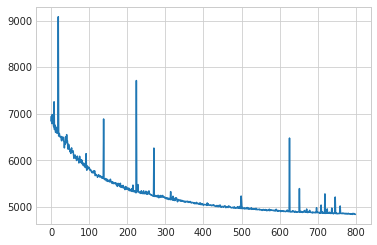

In [144]:
plt.plot(zinbayes.model_inst.loss_dict['t_loss'][200:])

In [202]:
obj = ZINBayes(n_components=K, n_mc_samples=10)
zinbayes = ModelWrapper(obj, X, name='ZINBayes', do_imp=True)
zinbayes.run(max_iter=1000, do_silh=True, do_dll=True, do_holl=True, do_tsne=False, verbose=True)

Considering zero-inflation.
Considering cell-specific scalings.
Running ZINBayes...
1000/1000 [100%] ██████████████████████████████ Elapsed: 252s | Loss: 4727.962
Done.


In [203]:
zinbayes.dropimp_err

181.6969

In [ ]:
print_utils.print_full_report([zinbayes, mpcmf, scvi], cluster=True, test_ll=False)

# Plot results

In [116]:
colors = sns.color_palette("Set1", 10, desat=.7) # this is a list of 10 colors

# We must choose what color to assign to each model
model_list_clustering = [mpcmf_full_reps, zinbayes_full_reps, zinbwave_full_reps, scvi_full_reps, pcmf_full_reps, zifa_full_reps, fa_full_reps]
# model_list_ll = [mpcmf_cv, zinbayes_cv, zinbwave_cv, scvi_cv, zifa_cv, fa_cv]
model_list_imp = [mpcmf_imputation, zinbayes_imputation, zinbwave_imputation, scvi_imputation, pcmf_imputation, zifa_imputation]

# Colors
color_list_clustering = [colors[0], colors[1], colors[2], colors[4], colors[3], colors[5], colors[6]]
hatch_list_clustering = ['//', '//', None, None, None, None, None]
color_list_ll = [colors[0], colors[1], colors[2], colors[4], colors[5], colors[6]]
hatch_list_ll = ['//', '//', None, None, None, None]
color_list_imp = [colors[0], colors[1], colors[2], colors[4], colors[3], colors[5]]
hatch_list_imp = ['//', '//', None, None, None, None, None]

## Latent space clustering

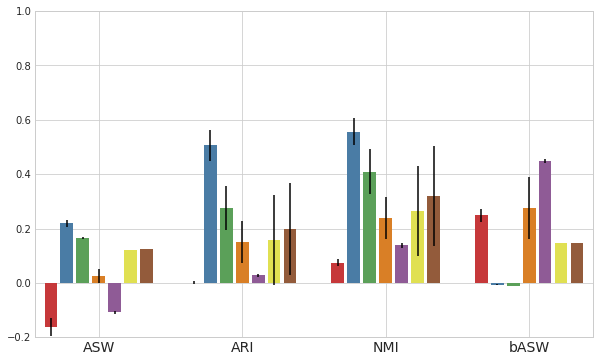

In [125]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
ax, _, _ = plot_utils.clustering_cv(model_list_clustering, colors=color_list_clustering, show_legend=False, ylim=[-.2, 1],
                            title=None, ax=ax, box=False, hatches=None);
ax.figure.savefig('POLLEN_clustering_bars.png', dpi=300, bbox_inches='tight')

In [34]:
model_list = [[mpcmf], [zinbayes], [zinbwave], [scvi], [pcmf], [zifa], [fa]]
colors = sns.color_palette("Set1", 10, desat=.7) # this is a list of 10 colors
color_list_clustering = [colors[0], colors[1], colors[2], colors[4], colors[3], colors[5], colors[6]]

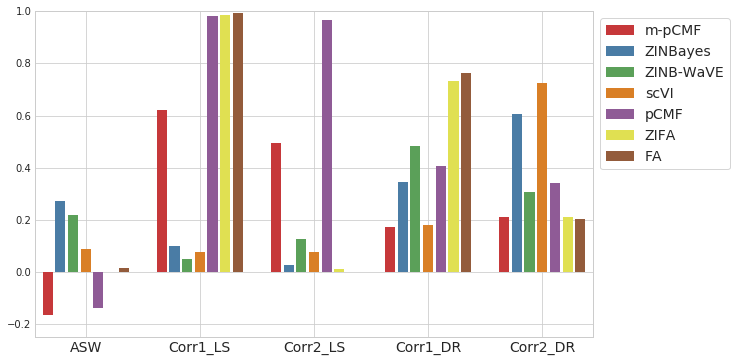

In [36]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
ax = plot_utils.clustering_cv(model_list, colors=color_list_clustering, show_legend=True, ylim=[-0.25, 1],
                            title=None, ax=ax, box=False, hatches=None);
ax.figure.savefig('POLLEN_2d_corrs.png', dpi=300, bbox_inches='tight')

In [48]:
b_names

array(['High', 'Low'], dtype=object)

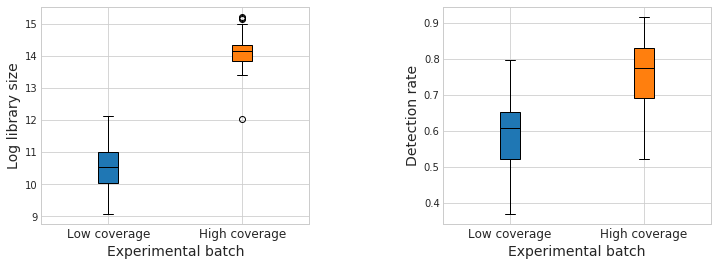

In [110]:
fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 2, 1)

bplot = plt.boxplot([np.log(np.sum(X[b_id==1], axis=1)), np.log(np.sum(X[b_id==0], axis=1))], patch_artist=True, )
ax.set_xticklabels(['Low coverage', 'High coverage'], fontsize=12)
plt.ylabel('Log library size', fontsize=14)
plt.xlabel('Experimental batch', fontsize=14)
for patch, color in zip(bplot['boxes'], plt.rcParams['axes.prop_cycle'].by_key()['color']):
    patch.set_facecolor(color)
for element in ['fliers', 'means', 'medians', 'caps']:
        plt.setp(bplot[element], color='black')
    
    
ax = plt.subplot(1, 2, 2)
bplot = plt.boxplot([np.sum(X[b_id==1] !=0, axis=1)/X.shape[1], np.sum(X[b_id==0]!=0, axis=1)/X.shape[1]], patch_artist=True)
ax.set_xticklabels(['Low coverage', 'High coverage'], fontsize=12)
plt.ylabel('Detection rate', fontsize=14)
plt.xlabel('Experimental batch', fontsize=14)
for patch, color in zip(bplot['boxes'], plt.rcParams['axes.prop_cycle'].by_key()['color']):
    patch.set_facecolor(color)
for element in ['fliers', 'means', 'medians', 'caps']:
        plt.setp(bplot[element], color='black')

fig.subplots_adjust(wspace=.5)
plt.savefig('POLLEN_corr_batches.png', dpi=300, bbox_inches='tight')

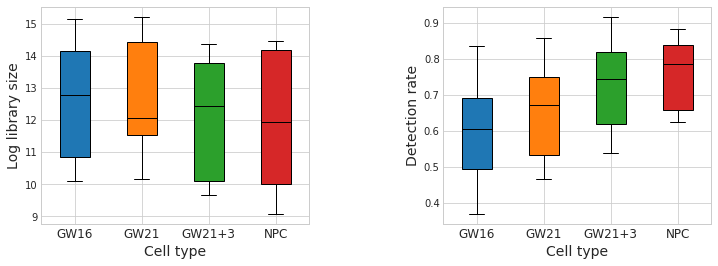

In [111]:
fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 2, 1)
bplot = plt.boxplot([np.log(np.sum(X[labels==0], axis=1)), np.log(np.sum(X[labels==1], axis=1)), 
             np.log(np.sum(X[labels==2], axis=1)), np.log(np.sum(X[labels==3], axis=1))], patch_artist=True)
ax.set_xticklabels([y_names[0], y_names[1], y_names[2], y_names[3]], fontsize=12)
plt.ylabel('Log library size', fontsize=14)
plt.xlabel('Cell type', fontsize=14)
for patch, color in zip(bplot['boxes'], plt.rcParams['axes.prop_cycle'].by_key()['color']):
    patch.set_facecolor(color)
for element in ['fliers', 'means', 'medians', 'caps']:
        plt.setp(bplot[element], color='black')

ax = plt.subplot(1, 2, 2)
bplot = plt.boxplot([np.sum(X[labels==0] !=0, axis=1)/X.shape[1], 
             np.sum(X[labels==1] !=0, axis=1)/X.shape[1], np.sum(X[labels==2] !=0, axis=1)/X.shape[1], 
             np.sum(X[labels==3]!=0, axis=1)/X.shape[1]], patch_artist=True)
ax.set_xticklabels([y_names[0], y_names[1], y_names[2], y_names[3]], fontsize=12)
plt.ylabel('Detection rate', fontsize=14)
plt.xlabel('Cell type', fontsize=14)
for patch, color in zip(bplot['boxes'], plt.rcParams['axes.prop_cycle'].by_key()['color']):
    patch.set_facecolor(color)
for element in ['fliers', 'means', 'medians', 'caps']:
        plt.setp(bplot[element], color='black')

fig.subplots_adjust(wspace=.5)
plt.savefig('POLLEN_corr_cells.png', dpi=300, bbox_inches='tight')

In [40]:
np.sum(X[b_id==1], axis=1)

array([ 20061., 184475.,  29641.,  53557., 104473.,  39415.,  35504.,
        17559.,  27729.,  18073.,  55242.,  63681.,  28461., 118991.,
        38284.,  38672., 164199., 144676.,  37900.,  71104.,  97723.,
        51671.,  19184.,  23812.,  21759.,  24081.,  45037.,  60537.,
        79241.,   8568.,  18552.,  19697.,  40408.,  37196.,  15818.,
        70113.,  63936.,  59289.,  22672.,  22692., 139107.,  27737.,
        44656.,  50350., 184290.,  24661.,  16220.,  73142.,  37290.,
        21171.,  25543.,  24283.,  34973.,  48296.,  43508.,  25887.,
        21244.,  22877.,  15440.,  59801.,  44420.,  22949.,  18919.,
        91637.,  32420.], dtype=float32)

In [39]:
np.sum(X[b_id==0], axis=1)

array([1215020., 3230357.,  979162.,  672583., 2609735., 2719483.,
       3237157., 1010136., 1440811., 1477854., 1502475.,  776063.,
       1386197., 1684855., 1221813., 1790301., 2210945.,  841664.,
       1613150., 3806109., 1259302., 1288366., 1705338., 1065082.,
       1268690., 1594036., 1466742., 1566211., 1628001.,  853256.,
        899982., 1520878., 4102509., 1836777., 1242306.,  166056.,
        819479.,  951929., 2176229., 1645382., 1446037., 1342748.,
       1749544., 1229469., 1349061., 1460706., 1010508., 1660678.,
       1275894., 1745026., 1380305.,  945822., 1046231.,  701080.,
        811656.,  761578., 1722584., 1405125., 1930104., 1297133.,
       1511543., 1161082.,  689851., 1665169., 3923960.], dtype=float32)

In [89]:
model_list_2d = [zinbayes, zinbwave, fa]

In [166]:
for model in model_list_2d:
    model.do_tsne()

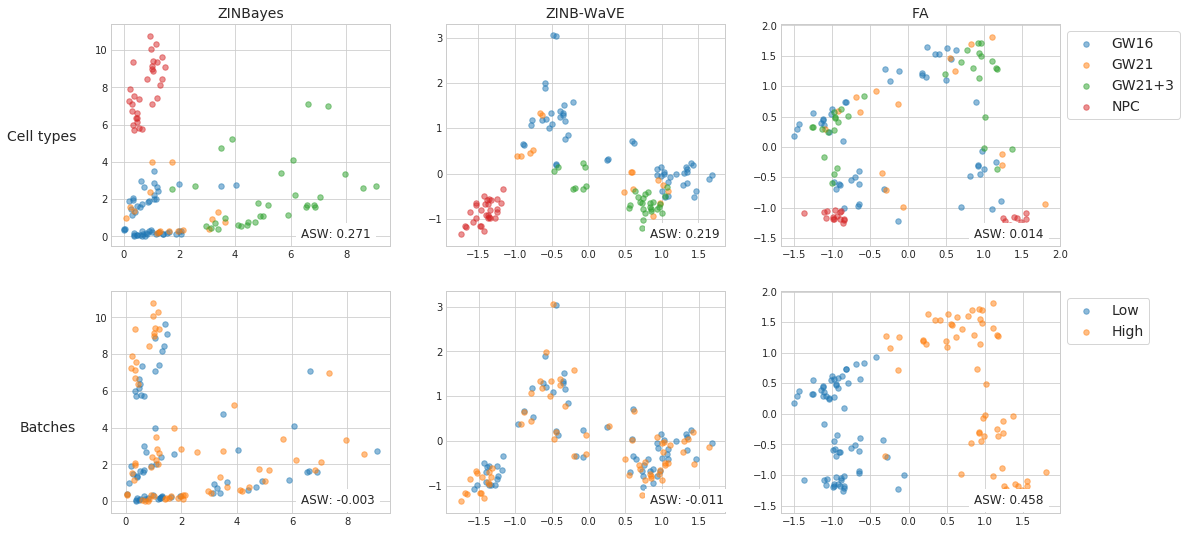

In [99]:
fig = plt.figure(figsize=(17, 9))

plt.figtext(0.04, .7, 'Cell types', fontsize=14)
plt.figtext(0.05, .25, 'Batches', fontsize=14)

ax = plt.subplot(2, 3, 1)
plot_utils.plot_tsne(model_list_2d[0].proj_2d[:], labels[:], ax=ax, title=model_list_2d[0].name, s=s)
plt.figtext(0.28, .55, 'ASW: {:.3f}'.format(model_list_2d[0].asw), fontsize=12, bbox=dict(facecolor='white', edgecolor='none', pad=5.0))

ax = plt.subplot(2, 3, 2)
plot_utils.plot_tsne(model_list_2d[1].proj_2d, labels, ax=ax, title=model_list_2d[1].name, s=s)
plt.figtext(0.565, .55, 'ASW: {:.3f}'.format(model_list_2d[1].asw), fontsize=12, bbox=dict(facecolor='white', edgecolor='none', pad=5.0))

ax = plt.subplot(2, 3, 3)
plot_utils.plot_tsne(model_list_2d[2].proj_2d, labels, ax=ax, title=model_list_2d[2].name, s=s, labels=clusters, legend=True, ncol=1, bbox_to_anchor=[1., 1.])
plt.figtext(0.83, .55, 'ASW: {:.3f}'.format(model_list_2d[2].asw), fontsize=12, bbox=dict(facecolor='white', edgecolor='none', pad=5.0))

ax = plt.subplot(2, 3, 4)
plot_utils.plot_tsne(model_list_2d[0].proj_2d, b_onehot[:, 0], ax=ax, s=s)
plt.figtext(0.28, .14, 'ASW: {:.3f}'.format(model_list_2d[0].batch_asw), fontsize=12, bbox=dict(facecolor='white', edgecolor='none', pad=5.0))

ax = plt.subplot(2, 3, 5)
plot_utils.plot_tsne(model_list_2d[1].proj_2d, b_onehot[:, 0], ax=ax, s=s)
plt.figtext(0.565, .14, 'ASW: {:.3f}'.format(model_list_2d[1].batch_asw), fontsize=12, bbox=dict(facecolor='white', edgecolor='none', pad=5.0))

ax = plt.subplot(2, 3, 6)
plot_utils.plot_tsne(model_list_2d[2].proj_2d, b_onehot[:, 0], ax=ax, s=s, labels=b, legend=True, ncol=1, bbox_to_anchor=[1., 1.])
plt.figtext(0.83, .14, 'ASW: {:.3f}'.format(model_list_2d[2].batch_asw), fontsize=12, bbox=dict(facecolor='white', edgecolor='none', pad=5.0))

plt.savefig('POLLEN_2d_clustering_batch.png', dpi=300, bbox_inches='tight')
# sys.__stdout__.write("*** Saved clustering batch 2d image to file.\n");

In [191]:
mpcmf_full_reps[0].asw, mpcmf_full_reps[0].batch_asw

(-0.2147437402476633, 0.21011488397366976)

In [192]:
zinbayes_full_reps[0].asw, zinbayes_full_reps[0].batch_asw

(0.23045523, -0.00674609)

In [193]:
fa_full_reps[0].asw, fa_full_reps[0].batch_asw

(0.12577307792643763, 0.14871482170551875)

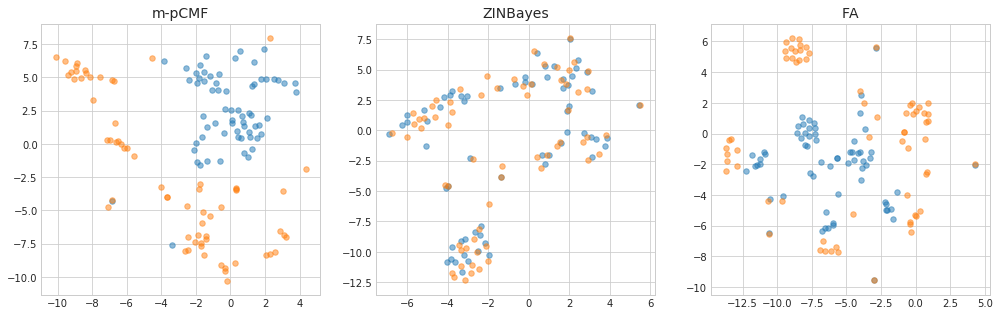

In [172]:
fig = plt.figure(figsize=(17, 5))
ax = plt.axes()
plot_utils.plot_2d(model_list_2d, b_onehot[:, 0], nrows=1, ncols=3, ax=ax, 
                          labels=None, legend=True, bbox_to_anchor=[1.2, 1.], titles=True)

In [196]:
mpcmf_imputation[0].dropimp_err

153.7583843415353

### Correlation with quality metrics

In [ ]:
fa_full_reps[0].asw, fa_full_reps[0].ari, fa_full_reps[0].nmi

In [ ]:
fa_full_reps[0].do_tsne()

In [ ]:
plot_utils.plot_tsne(fa_full_reps[0].proj_2d, y_collapsed_id)

## Held-out data log-likelihood

In [ ]:
plt.figure(figsize=(10, 6))
ax = plt.axes()
ax, _, _= plot_utils.loglikelihood_cv(model_list_ll, colors=color_list_ll, show_legend=False, hatches=hatch_list_ll,
                            title=None, ax=ax, box=False);
ax.figure.savefig('ZEISEL_ll.png', dpi=300, bbox_inches='tight')

156.1713274444511

## Imputation error

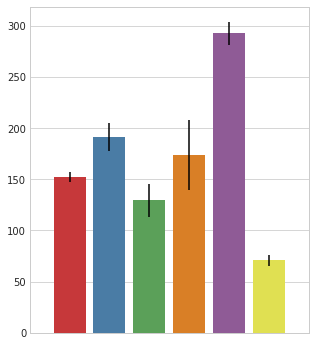

In [213]:
plt.figure(figsize=(5, 6))
ax = plt.axes()
ax, _, _ = plot_utils.imputationerr_boxplot(model_list_imp, colors=color_list_imp, 
                                 show_legend=False, ax=ax, box=False, hatches=None);
ax.figure.savefig('POLLEN_imp.png', dpi=300, bbox_inches='tight')

In [135]:
mpcmf.est_R[:10, :2]

array([[1.01370019e+03, 1.25844982e+01],
       [4.27195280e+00, 1.02801232e+01],
       [1.34633647e+02, 5.17413321e+01],
       [3.15266932e+02, 4.49446326e+02],
       [4.18715890e+02, 1.39578878e+01],
       [4.75852911e+02, 1.36452713e+03],
       [7.98676014e+02, 3.49379306e+02],
       [2.03888802e-01, 1.98229595e+02],
       [7.16036230e+01, 3.64811969e+03],
       [2.83419386e+02, 1.05447664e+02]])

In [137]:
mpcmf.est_norm_R[:10, :2]

array([[9.31602483e+02, 1.15653029e+01],
       [4.20007325e+00, 1.01071506e+01],
       [1.22135888e+02, 4.69382929e+01],
       [2.99619575e+02, 4.27139365e+02],
       [3.88645753e+02, 1.29555003e+01],
       [4.59170421e+02, 1.31668943e+03],
       [7.65310683e+02, 3.34783705e+02],
       [1.92102477e-01, 1.86770415e+02],
       [6.73444261e+01, 3.43111866e+03],
       [2.67676268e+02, 9.95903543e+01]])

In [140]:
mpcmf_imputation[0].corruption_info

{'X_corr': array([[0.00000e+00, 0.00000e+00, 1.28700e+03, ..., 3.18810e+04,
         2.99190e+04, 5.89550e+04],
        [0.00000e+00, 9.00000e+00, 0.00000e+00, ..., 8.40000e+01,
         2.42000e+02, 9.57000e+02],
        [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 8.14040e+04,
         1.69370e+05, 7.20000e+01],
        ...,
        [9.00000e+00, 0.00000e+00, 0.00000e+00, ..., 2.69400e+04,
         3.07230e+04, 4.99800e+04],
        [0.00000e+00, 0.00000e+00, 9.00000e+01, ..., 1.01949e+05,
         2.66070e+04, 3.62440e+04],
        [1.00000e+00, 0.00000e+00, 0.00000e+00, ..., 6.13000e+03,
         8.68990e+04, 1.19330e+04]], dtype=float32),
 'i': array([  0,   0,   0, ..., 129, 129, 129]),
 'j': array([  1,   2,   3, ..., 997, 998, 999]),
 'ix': array([20161,  7173,  6908, ..., 61896, 62097, 55335])}

## Technical variability

In [ ]:
log_library_size = np.log(np.sum(X, axis=1))

In [ ]:
from scipy.stats import pearsonr

In [ ]:
fig = plt.figure(figsize=(15,4))

ax = plt.subplot(1, 3, 1)
est_l = zinbayes_full_reps[1].model_inst.est_L
plt.scatter(np.log(est_l.ravel()), log_library_size, alpha=0.5, s=30)
plt.ylabel('log library size', fontsize=14)
plt.xlabel('log cell scaling', fontsize=14)
plt.title('ZINBayes (corr={:.4f})'.format(pearsonr(np.log(est_l).ravel(), log_library_size.ravel())[0]), fontsize=14)
# plt.xlim(log_library_size.min(), log_library_size.max())

ax = plt.subplot(1, 3, 2, sharey=ax)
est_l = mpcmf_full_reps[1].est_L
plt.scatter(np.log(est_l.ravel()), log_library_size, alpha=0.5, s=30)
# plt.ylabel('log-library size')
plt.xlabel('log cell scaling', fontsize=14)
plt.title('m-pCMF (corr={:.4f})'.format(pearsonr(np.log(est_l).ravel(), log_library_size.ravel())[0]), fontsize=14)
# plt.xlim(log_library_size.min(), log_library_size.max())

ax = plt.subplot(1, 3, 3, sharey=ax)
est_l = scvi_full_reps[1].model_inst.est_L
plt.scatter(est_l.ravel(), log_library_size, alpha=0.5, s=30)
# plt.ylabel('log-library size')
plt.xlabel('log cell scaling', fontsize=14)
plt.title('scVI (corr={:.4f})'.format(pearsonr(np.log(est_l).ravel(), log_library_size.ravel())[0]), fontsize=14)
# plt.xlim(log_library_size.min(), log_library_size.max())
fig.savefig('ZEISEL_scalings.png', dpi=300, bbox_inches='tight')
plt.show()

## Gene groups

## Differential Expression

In [ ]:
"""
Poisson matrix factorization with Batch inference and Stochastic inference
CREATED: 2014-03-25 02:06:52 by Dawen Liang <dliang@ee.columbia.edu>
"""

import sys
import numpy as np
from scipy import special

from sklearn.base import BaseEstimator, TransformerMixin


class PoissonMF(BaseEstimator, TransformerMixin):
    ''' Poisson matrix factorization with batch inference '''
    def __init__(self, n_components=100, max_iter=100, tol=0.0005,
                 smoothness=100, random_state=None, verbose=False,
                 **kwargs):
        ''' Poisson matrix factorization
        Arguments
        ---------
        n_components : int
            Number of latent components
        max_iter : int
            Maximal number of iterations to perform
        tol : float
            The threshold on the increase of the objective to stop the
            iteration
        smoothness : int
            Smoothness on the initialization variational parameters
        random_state : int or RandomState
            Pseudo random number generator used for sampling
        verbose : bool
            Whether to show progress during model fitting
        **kwargs: dict
            Model hyperparameters
        '''

        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.smoothness = smoothness
        self.random_state = random_state
        self.verbose = verbose

        if type(self.random_state) is int:
            np.random.seed(self.random_state)
        elif self.random_state is not None:
            np.random.setstate(self.random_state)

        self._parse_args(**kwargs)

    def _parse_args(self, **kwargs):
        self.a = float(kwargs.get('a', 16.))
        self.b = float(kwargs.get('b', 4.))

    def _init_components(self, n_feats):
        # variational parameters for beta
        self.gamma_b = self.smoothness \
            * np.random.gamma(self.smoothness, 1. / self.smoothness,
                              size=(self.n_components, n_feats))
        self.rho_b = self.smoothness \
            * np.random.gamma(self.smoothness, 1. / self.smoothness,
                              size=(self.n_components, n_feats))
        self.Eb, self.Elogb = _compute_expectations(self.gamma_b, self.rho_b)

    def set_components(self, shape, rate):
        '''Set the latent components from variational parameters.
        Parameters
        ----------
        shape : numpy-array, shape (n_components, n_feats)
            Shape parameters for the variational distribution
        rate : numpy-array, shape (n_components, n_feats)
            Rate parameters for the variational distribution
        Returns
        -------
        self : object
            Return the instance itself.
        '''

        self.gamma_b, self.rho_b = shape, rate
        self.Eb, self.Elogb = _compute_expectations(self.gamma_b, self.rho_b)
        return self

    def _init_weights(self, n_samples):
        # variational parameters for theta
        self.gamma_t = self.smoothness \
            * np.random.gamma(self.smoothness, 1. / self.smoothness,
                              size=(n_samples, self.n_components))
        self.rho_t = self.smoothness \
            * np.random.gamma(self.smoothness, 1. / self.smoothness,
                              size=(n_samples, self.n_components))
        self.Et, self.Elogt = _compute_expectations(self.gamma_t, self.rho_t)
        self.c = 1. / np.mean(self.Et)

    def fit(self, X):
        '''Fit the model to the data in X.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_feats)
            Training data.
        Returns
        -------
        self: object
            Returns the instance itself.
        '''
        n_samples, n_feats = X.shape
        self._init_components(n_feats)
        self._init_weights(n_samples)
        self._update(X)
        return self

    def transform(self, X, attr=None):
        '''Encode the data as a linear combination of the latent components.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_feats)
        attr: string
            The name of attribute, default 'Eb'. Can be changed to Elogb to
            obtain E_q[log beta] as transformed data.
        Returns
        -------
        X_new : array-like, shape(n_samples, n_filters)
            Transformed data, as specified by attr.
        '''

        if not hasattr(self, 'Eb'):
            raise ValueError('There are no pre-trained components.')
        n_samples, n_feats = X.shape
        if n_feats != self.Eb.shape[1]:
            raise ValueError('The dimension of the transformed data '
                             'does not match with the existing components.')
        if attr is None:
            attr = 'Et'
        self._init_weights(n_samples)
        self._update(X, update_beta=False)
        return getattr(self, attr)

    def _update(self, X, update_beta=True):
        # alternating between update latent components and weights
        old_bd = -np.inf
        for i in range(self.max_iter):
            self._update_theta(X)
            if update_beta:
                self._update_beta(X)
            bound = self._bound(X)
            improvement = (bound - old_bd) / abs(old_bd)
            if self.verbose:
                sys.stdout.write('\r\tAfter ITERATION: %d\tObjective: %.2f\t'
                                 'Old objective: %.2f\t'
                                 'Improvement: %.5f' % (i, bound, old_bd,
                                                        improvement))
                sys.stdout.flush()
            if improvement < self.tol:
                break
            old_bd = bound
        if self.verbose:
            sys.stdout.write('\n')
        pass

    def _update_theta(self, X):
        ratio = X / self._xexplog()
        self.gamma_t = self.a + np.exp(self.Elogt) * np.dot(
            ratio, np.exp(self.Elogb).T)
        self.rho_t = self.a * self.c + np.sum(self.Eb, axis=1)
        self.Et, self.Elogt = _compute_expectations(self.gamma_t, self.rho_t)
        self.c = 1. / np.mean(self.Et)

    def _update_beta(self, X):
        ratio = X / self._xexplog()
        self.gamma_b = self.b + np.exp(self.Elogb) * np.dot(
            np.exp(self.Elogt).T, ratio)
        self.rho_b = self.b + np.sum(self.Et, axis=0, keepdims=True).T
        self.Eb, self.Elogb = _compute_expectations(self.gamma_b, self.rho_b)

    def _xexplog(self):
        '''
        sum_k exp(E[log theta_{ik} * beta_{kd}])
        '''
        return np.dot(np.exp(self.Elogt), np.exp(self.Elogb))

    def _bound(self, X):
        bound = np.sum(X * np.log(self._xexplog()) - self.Et.dot(self.Eb))
        bound += _gamma_term(self.a, self.a * self.c,
                             self.gamma_t, self.rho_t,
                             self.Et, self.Elogt)
        bound += self.n_components * X.shape[0] * self.a * np.log(self.c)
        bound += _gamma_term(self.b, self.b, self.gamma_b, self.rho_b,
                             self.Eb, self.Elogb)
        return bound
    
def _compute_expectations(alpha, beta):
    '''
    Given x ~ Gam(alpha, beta), compute E[x] and E[log x]
    '''
    return (alpha / beta, special.psi(alpha) - np.log(beta))


def _gamma_term(a, b, shape, rate, Ex, Elogx):
    return np.sum((a - shape) * Elogx - (b - rate) * Ex +
                  (special.gammaln(shape) - shape * np.log(rate)))